## Import Libraries

In [1]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
# from google.colab import auth
from google.cloud import bigquery
import bigframes.pandas as bf


## Mimic


In [2]:
# Set up environment variables
project_id = 'circular-study-420112'
if project_id == 'velv':
  raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(bigquery, project_id=project_id):
  return pd.io.gbq.read_gbq(
      bigquery,
      project_id=project_id,
      dialect='standard')

# set the dataset
# if you want to use the demo, change this to mimic_demo
dataset = 'mimiciv'

## Patients Information for ICD

In [4]:
query_sepsis_patients = """
SELECT DISTINCT
    d.subject_id,
    d.hadm_id,
    icu.stay_id,
    d.icd_code,
    d.icd_version
FROM
    `physionet-data.mimiciv_hosp.diagnoses_icd` d
JOIN
    `physionet-data.mimiciv_icu.icustays` icu
    ON d.hadm_id = icu.hadm_id
WHERE
    (d.icd_version = 9 AND d.icd_code IN ('99591', '99592', '78552'))
    OR (d.icd_version = 10 AND d.icd_code IN ('A40', 'A41', 'R652', 'A403', 'A408', 'A409', 'O85', 'A427'))

"""
patients_df = bf.read_gbq(query_sepsis_patients)
# patients_df.to_csv('sepsis_patients.csv', index=False)

## Using Speis defination -1  

## Vital Signs Data

In [5]:
query_vital_signs = """

WITH sepsis_patients AS (
    SELECT DISTINCT
        d.subject_id,
        d.hadm_id,
        icu.stay_id
    FROM
        physionet-data.mimiciv_hosp.diagnoses_icd d
    JOIN
        physionet-data.mimiciv_icu.icustays icu
    ON d.hadm_id = icu.hadm_id
    WHERE
        (d.icd_version = 9 AND d.icd_code IN ('99591', '99592', '78552'))
        OR (d.icd_version = 10 AND d.icd_code IN ('A40', 'A41', 'R652', 'A403', 'A408', 'A409', 'O85', 'A427'))
),
patient_info AS (
    SELECT
        icu.subject_id,
        icu.hadm_id,
        icu.stay_id,
        pat.anchor_age AS age,
        icu.intime,
        icu.outtime
    FROM
        physionet-data.mimiciv_icu.icustays icu
    JOIN
        physionet-data.mimiciv_hosp.patients pat
    ON icu.subject_id = pat.subject_id
    WHERE pat.anchor_age >= 18  -- Select only adult patients
)
SELECT
    v.subject_id,
    v.hadm_id,
    v.stay_id,
    v.charttime,
    pi.age,  -- Including the age from patient_info
    MAX(CASE WHEN di.label = 'Heart Rate' THEN v.valuenum END) AS heart_rate,
    MAX(CASE WHEN di.label = 'Temperature Fahrenheit' THEN v.valuenum END) AS temperature,
    MAX(CASE WHEN di.label = 'Respiratory Rate' THEN v.valuenum END) AS resp_rate,
    MAX(CASE WHEN di.label = 'Arterial Blood Pressure systolic' OR di.label = 'Non Invasive Blood Pressure systolic' THEN v.valuenum END) AS systolic_bp,
    MAX(CASE WHEN di.label = 'Arterial Blood Pressure diastolic' OR di.label = 'Non Invasive Blood Pressure diastolic' THEN v.valuenum END) AS diastolic_bp,
    MAX(CASE WHEN di.label = 'O2 saturation pulseoxymetry' OR di.label = 'Arterial O2 Saturation' THEN v.valuenum END) AS blood_oxygen_saturation,
    MAX(CASE WHEN di.label = 'Arterial CO2 Pressure' THEN v.valuenum END) AS co2_partial_pressure
FROM
    physionet-data.mimiciv_icu.chartevents v
JOIN
    physionet-data.mimiciv_icu.d_items di
    ON v.itemid = di.itemid
JOIN
    sepsis_patients sp
    ON v.subject_id = sp.subject_id AND v.hadm_id = sp.hadm_id AND v.stay_id = sp.stay_id
JOIN
    patient_info pi
    ON v.subject_id = pi.subject_id AND v.hadm_id = pi.hadm_id AND v.stay_id = pi.stay_id
WHERE
    di.label IN ('Heart Rate', 'Temperature Fahrenheit', 'Respiratory Rate',
                 'Arterial Blood Pressure systolic', 'Non Invasive Blood Pressure systolic',
                 'Arterial Blood Pressure diastolic', 'Non Invasive Blood Pressure diastolic',
                 'O2 saturation pulseoxymetry', 'Arterial O2 Saturation',
                 'Arterial CO2 Pressure')
GROUP BY
    v.subject_id, v.hadm_id, v.stay_id, v.charttime, pi.age
ORDER BY
    v.charttime;
"""
signs_df = bf.read_gbq(query_vital_signs)

In [6]:
signs_df

,subject_id,hadm_id,stay_id,charttime,age,heart_rate,temperature,resp_rate,systolic_bp,diastolic_bp,blood_oxygen_saturation,co2_partial_pressure
0,18895046,21078339,38003602,2130-02-13 17:00:00,68,87.0,<NA>,9.0,180.0,72.0,100.0,<NA>
1,14338019,21236830,39953997,2150-11-14 10:25:00,83,114.0,<NA>,18.0,<NA>,<NA>,93.0,<NA>
2,19315586,25927231,37875725,2185-09-04 01:00:00,91,84.0,<NA>,18.0,146.0,54.0,100.0,<NA>
3,11482582,22946206,38042707,2128-01-18 02:00:00,46,86.0,<NA>,26.0,<NA>,<NA>,98.0,<NA>
4,15401089,29659924,39357519,2123-03-24 23:06:00,63,106.0,101.5,24.0,124.0,60.0,93.0,<NA>
5,17084981,24169076,33071977,2128-02-14 05:00:00,78,86.0,97.0,26.0,<NA>,<NA>,100.0,<NA>
6,14726060,22127379,36540622,2144-03-02 21:00:00,79,94.0,<NA>,18.0,149.0,52.0,97.0,<NA>
7,12433421,20901543,37062532,2151-03-03 00:00:00,69,104.0,97.8,17.0,109.0,67.0,100.0,<NA>
8,15879362,25420179,30451433,2181-12-16 15:50:00,63,<NA>,<NA>,<NA>,99.0,57.0,<NA>,<NA>
9,19132043,24959439,35053702,2121-11-14 15:30:00,61,82.0,<NA>,30.0,95.0,49.0,100.0,<NA>


In [7]:
signs_df.to_csv('signs_with_AGE_all.csv', index=False)

## White Blood Cells from lab report

In [8]:
query_lab_values = """
WITH sepsis_patients AS (
    SELECT DISTINCT
        d.subject_id,
        d.hadm_id,
        icu.stay_id,
        pat.anchor_age AS age,
        icu.intime,
        d.icd_code
    FROM
        physionet-data.mimiciv_hosp.diagnoses_icd d
    JOIN
        physionet-data.mimiciv_icu.icustays icu
    ON d.hadm_id = icu.hadm_id
    JOIN
        physionet-data.mimiciv_hosp.patients pat
    ON icu.subject_id = pat.subject_id
    WHERE
        pat.anchor_age >= 18
        AND ((d.icd_version = 9 AND d.icd_code IN ('99591', '99592', '78552'))
        OR (d.icd_version = 10 AND d.icd_code IN ('A40', 'A41', 'R652', 'A403', 'A408', 'A409', 'O85', 'A427')))
)
SELECT
    l.subject_id,
    l.hadm_id,
    l.charttime,
    sp.icd_code,
    MAX(CASE WHEN di.label LIKE 'White Blood Cell%' THEN l.valuenum END) AS white_blood_cells
FROM
    physionet-data.mimiciv_hosp.labevents l
JOIN
    physionet-data.mimiciv_hosp.d_labitems di
    ON l.itemid = di.itemid
JOIN
    sepsis_patients sp
    ON l.subject_id = sp.subject_id AND l.hadm_id = sp.hadm_id
WHERE
    di.label LIKE 'White Blood Cell%'
GROUP BY
    l.subject_id, l.hadm_id, l.charttime, sp.icd_code
ORDER BY
    l.charttime;
"""

# Run and save as CSV
values_all_df = bf.read_gbq(query_lab_values)
values_all_df.to_csv('values_all.csv', index=False)

In [9]:
values_all_df

,subject_id,hadm_id,charttime,icd_code,white_blood_cells
0,13042648,26157365,2159-06-22 04:10:00,78552,17.6
1,13280475,23801548,2186-09-18 02:56:00,99592,5.4
2,16924642,26159594,2189-09-14 08:45:00,99591,8.2
3,15842422,20195368,2169-10-09 06:38:00,99591,13.9
4,17292940,28354137,2134-08-22 05:59:00,78552,1.9
5,11067883,27965174,2146-10-16 00:08:00,99591,3.1
6,14606038,26446300,2174-06-26 04:53:00,99592,9.5
7,15850072,24051036,2141-02-01 00:00:00,78552,2.6
8,19237156,23630622,2140-01-24 05:59:00,99592,8.5
9,19787095,23981090,2168-03-09 02:32:00,99591,15.1


## Getting Ph data from lab values

In [10]:
query_lab_values = """
WITH sepsis_patients AS (
    SELECT DISTINCT
        d.subject_id,
        d.hadm_id,
        icu.stay_id,
        pat.anchor_age AS age,
        icu.intime,
        d.icd_code
    FROM
        `physionet-data.mimiciv_hosp.diagnoses_icd` d
    JOIN
        `physionet-data.mimiciv_icu.icustays` icu
    ON d.hadm_id = icu.hadm_id
    JOIN
        `physionet-data.mimiciv_hosp.patients` pat
    ON icu.subject_id = pat.subject_id
    WHERE
        pat.anchor_age >= 18
        AND ((d.icd_version = 9 AND d.icd_code IN ('99591', '99592', '78552'))
        OR (d.icd_version = 10 AND d.icd_code IN ('A40', 'A41', 'R652', 'A403', 'A408', 'A409', 'O85', 'A427')))
)
SELECT
    l.subject_id,
    l.hadm_id,
    l.charttime,
    sp.icd_code,
    MAX(CASE WHEN di.label LIKE 'pH' THEN l.valuenum END) AS ph_value
FROM
    `physionet-data.mimiciv_hosp.labevents` l
JOIN
    `physionet-data.mimiciv_hosp.d_labitems` di
    ON l.itemid = di.itemid
JOIN
    sepsis_patients sp
    ON l.subject_id = sp.subject_id AND l.hadm_id = sp.hadm_id
WHERE
    di.label LIKE 'pH'
GROUP BY
    l.subject_id, l.hadm_id, l.charttime, sp.icd_code
ORDER BY
    l.charttime;

"""

# Run and save as CSV
PH_all_df = bf.read_gbq(query_lab_values)
PH_all_df.to_csv('PH_all.csv', index=False)

In [11]:
PH_all_df

,subject_id,hadm_id,charttime,icd_code,ph_value
0,14918516,22852565,2177-08-26 17:10:00,99592,7.45
1,12211587,28284188,2181-10-31 10:15:00,99592,7.39
2,19193700,27678541,2194-05-23 22:54:00,99592,7.27
3,16808621,27150302,2128-07-29 18:52:00,78552,7.37
4,16533299,29028790,2168-01-08 14:09:00,99592,7.5
5,19723798,26593663,2150-12-12 11:03:00,99592,7.29
6,12601474,20931771,2131-02-18 09:26:00,99592,7.49
7,13135946,22133572,2143-08-09 12:50:00,78552,7.49
8,11570162,20562374,2133-03-07 03:04:00,78552,7.28
9,14998916,22487973,2176-04-06 10:05:00,78552,7.3


### Digital Phenotypes model information

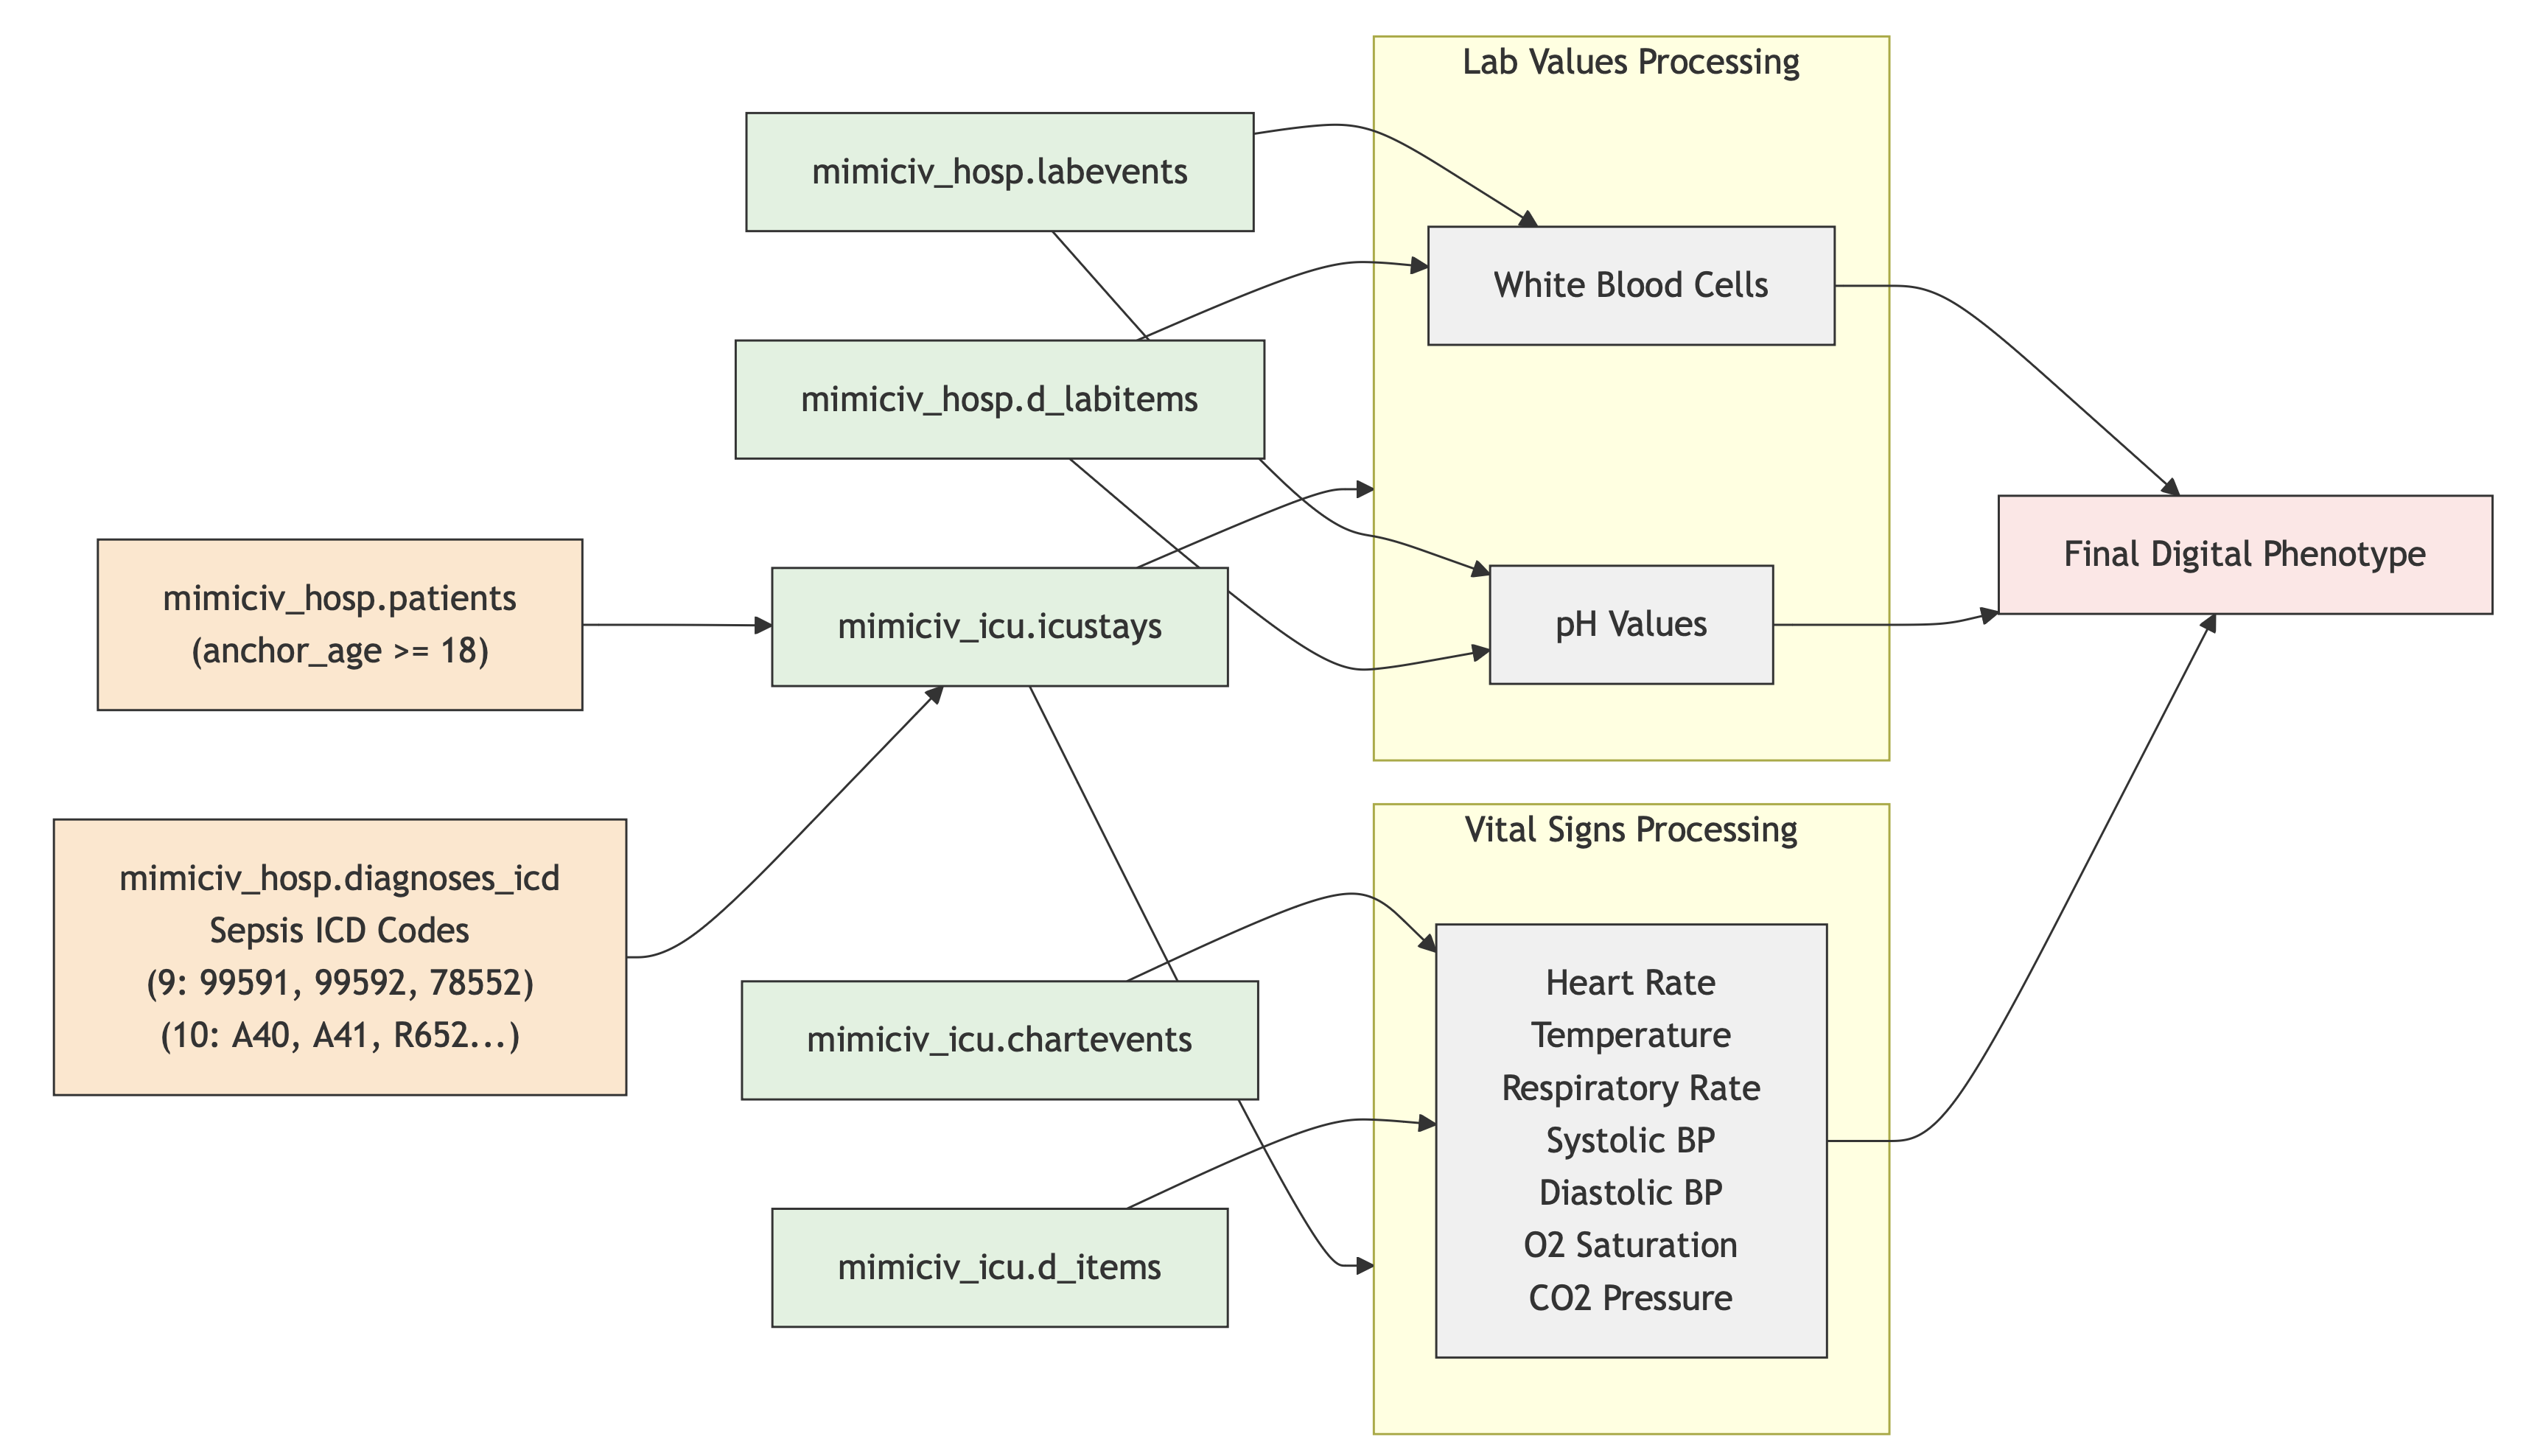

After generating digital phenotypes and merging the data into separate files, I am conducting time series analysis using a deep learning model, which requires substantial computational resources. I am now setting up a new file dedicated to data preprocessing and model development.